In [2]:
# Step 1: Import libraries and get the file upload
!pip install matplotlib
import ipywidgets as widgets
from ipywidgets import FileUpload
from ipywidgets import Output
from io import StringIO
from IPython.display import display
import pandas as pd
from pandas import read_table
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from pylab import *


In [3]:

#File uploader - must be direct, unmodified, original CSV as in backend
%matplotlib notebook

uploader = FileUpload(
    accept='*.csv',  # Accept only .csv files'
    multiple=False  # Accept only single files
)
uploader

button = widgets.Button(description='Graph the trip')
out = widgets.Output()

def on_button_clicked(_):
      # "linking function with output"
      startup()
   
# linking button and function together using a button's method
button.on_click(on_button_clicked)
widgets.VBox([button,out])

In [8]:
uploaded_filename = next(iter(uploader.value))

def content_parser():
    if uploader.value == {}:
        with out:
            print('No CSV loaded')    
    else:
        typ, content = "", ""
        up_value = uploader.value
        for i in up_value.keys():
            typ = up_value[i]["metadata"]["type"]        
        if typ == "text/csv":
            content = up_value[i]["content"]
            content_str = str(content, 'utf-8')
            if content_str != "":
                str_io = StringIO(content_str) 
                return str_io

def df_converter():
    content = content_parser()
    print("processing trip recording data..")
    if content is not None:
        df = pd.read_csv(
             content, 
             index_col=False)    
        return df
    else:
        return None

trip_recording = df_converter()
print("Trip recording data processed - execute the next step")

# ANALYSE THE FILE

zero_speeds = []
error_count = 0

clutch_max = 0
clutch_start = 0
clutch_start = 0
Estimated_power = []
Est_power_min = []
Est_power_max = []
band = int(0.1)

#Error_counter checks for errors in vehicle speed, throttle voltage and battery power
def error_counter():
    global error_count
    for x in trip_recording['1x260 - vehicle speed']:
        if x == "UnknownError":
            error_count += 1
        elif x == "TimeoutBluetooth":
            error_count += 1
    for x in trip_recording['1x270 - throttle voltage']:
        if x == "UnknownError":
            error_count += 1
        elif x == "TimeoutBluetooth":
            error_count += 1
    for x in trip_recording['1x268 - battery power']:
        if x == "UnknownError":
            error_count += 1
        elif x == "TimeoutBluetooth":
            error_count += 1
    for x in trip_recording['1x265 - battery voltage']:
        if x == "UnknownError":
            error_count += 1
        elif x == "TimeoutBluetooth":
            error_count += 1

 #error_fix will find and replace the errors   
def error_fix():
    trip_recording['1x260 - vehicle speed'] = trip_recording['1x260 - vehicle speed'].replace(["TimeoutBluetooth"], "")
    trip_recording['1x268 - battery power'] = trip_recording['1x268 - battery power'].replace(["TimeoutBluetooth"], "")
    trip_recording['1x270 - throttle voltage'] = trip_recording['1x270 - throttle voltage'].replace(["TimeoutBluetooth"], "")
    trip_recording['1x265 - battery voltage'] = trip_recording['1x265 - battery voltage'].replace(["TimeoutBluetooth"], "")
    trip_recording['1x260 - vehicle speed'] = trip_recording['1x260 - vehicle speed'].replace(["UnknownError"], "")
    trip_recording['1x268 - battery power'] = trip_recording['1x268 - battery power'].replace(["UnknownError"], "")
    trip_recording['1x270 - throttle voltage'] = trip_recording['1x270 - throttle voltage'].replace(["UnknownError"], "")
    trip_recording['1x265 - battery voltage'] = trip_recording['1x265 - battery voltage'].replace(["UnknownError"], "")
    trip_recording['1x268 - battery power'] = pd.to_numeric(trip_recording['1x268 - battery power'])
    trip_recording['1x270 - throttle voltage'] = pd.to_numeric(trip_recording['1x270 - throttle voltage'])
    trip_recording['1x260 - vehicle speed'] = pd.to_numeric(trip_recording['1x260 - vehicle speed'])
    trip_recording['1x265 - battery voltage'] = pd.to_numeric(trip_recording['1x265 - battery voltage'])

def find_zero_speed():
    counter = 0
    for x in trip_recording['1x260 - vehicle speed']:
        counter += 1
        if x == 0:
            zero_speeds.append(counter)
     
def battery_voltage_range():
    print("--------- Battery Power Test ---------")
    if trip_recording['1x265 - battery voltage'].min() > 32 and trip_recording['1x265 - battery voltage'].max() < 43:
        print("Battery range is OK --> ",trip_recording['1x265 - battery voltage'].min(), "volts to", trip_recording['1x265 - battery voltage'].max(),"volts")
    print(" ")

def plots():
        #all below is the new plot plan
    fig, ax = plt.subplots()

    plt.subplot(2,1,1)
    trip_recording['1x270 - throttle voltage'].plot(label='Torque Sensor', color = 'C0')
    plt.ylabel('Torque Sensor', color = 'C0')
    trip_recording['1x268 - battery power'].plot(secondary_y=['1x268 - battery power'], color = 'C1')
    plt.title('Torque Sensor (volts) vs Motor Power (watts)')
    plt.ylabel('Motor Power', color = 'C1')
    for x in zero_speeds: #changed (x,x+1, color) to (x,x,color) -it made the greying a bit nicer
        plt.axvspan(x,x, color='k', alpha=0.2)
    
    #plot the clutch issue
    if clutch_max > 10:
        plt.axvspan(clutch_start,clutch_start+clutch_max, color = 'red', alpha=0.2)
    plt.tight_layout()

    plt.subplot(2,1,2)
    trip_recording['1x268 - battery power'].plot(color='red')
    #trip_recording['1x268 - battery power'].plot(color='green',linewidth=7, alpha = 0.3) - 'perfect' view of how it should look
    plt.ylabel('Actual Motor Power', color = 'red')
    #plt.plot(Estimated_power, color='red', label = 'Estimated')
    plt.xlabel('Time(s)')
    plt.subplots_adjust(hspace = 0.2)
    plt.plot(Estimated_power, color = 'green', linewidth=7.0, alpha = 0.3, label = 'estimated power')
    if clutch_max > 10:
        plt.axvspan(clutch_start,clutch_start+clutch_max, color = 'red', alpha=0.2)
    #WANT THIS SOON: #plt.ylabel('Estimated Power Range', color = 'green')
    #plt.plot(Est_power_max, color = 'green', alpha = 0.3)
    #gca().set_position((.1, .3, .8, .6))
    
    plt.figtext(0.02, -0.02, "Tripadvisor v0.6 - File:   " + str(uploaded_filename) + "\n" 
    + "Vehicle speed is zero in grey areas, blank areas are where data errors were fixed \n \n" 
    + "Errors :    " + str(error_count) + "\n" + 
    str(clutch_message) + "\n" 
    + "Torque Sensor (volts):    " + "Min: " + str(round(trip_recording['1x270 - throttle voltage'].min(), 2)) + " // Avg : " + str(round(trip_recording['1x270 - throttle voltage'].mean(), 2)) + " // Max : " + str(round(trip_recording['1x270 - throttle voltage'].max(), 2))
    + "\n" 
    + "Motor Power Average : " + str(round(trip_recording['1x268 - battery power'].mean(), 2)) + " Watts" "\n"
    + "Battery Voltage Range : " + str(round(trip_recording['1x265 - battery voltage'].min(), 2)) + " to " + str(round(trip_recording['1x265 - battery voltage'].max(), 2)) + " volts"
    + "\n \n ", size=10)

    fig.subplots_adjust(bottom=0.4)
    
    #ta_pic = AnnotationBbox(OffsetImage(ta_img, zoom=0.2), (40+10, 2), frameon=False)
    #ax.add_artist(ta_pic)
    plt.show()

def clutch_issue():
    #looks for consistent power at around 20-40:
    global trial_counter
    global clutch_max
    global clutch_start
    global clutch_message
    trial_counter = 0
    loop_count = 0

    for x in trip_recording['1x268 - battery power']:
        loop_count += 1
        if 10 < x < 100:
            trial_counter+=1
            if trial_counter > clutch_max:
                clutch_max = trial_counter
                clutch_start = (loop_count + 1) - trial_counter
                #print("new record", clutch_max, "at location", clutch_start)
        elif x > 100:
            trial_counter = 0
        elif x < 10:
            trial_counter = 0
    if clutch_max > 10:
        clutch_message = "Clutch Issue potentially detected at " + str(clutch_start) + " seconds, lasting for " + str(clutch_max) + " seconds (red highlight)"
    else:
        clutch_message = "Clutch issue: Not detected"

#def dead_spots():
    #look for deadspots
    #looks at motor power vs vehicle speed
    #trip_recording['1x260 - vehicle speed'].plot()
    #trip_recording['1x268 - battery power'].plot(secondary_y=['1x268 - battery power'])
    #plt.show()

def power_estimation():
    counttt = 0
    min_torque = 0.55
    max_torque = trip_recording['1x270 - throttle voltage'].max()
    for x in trip_recording['1x270 - throttle voltage']:
        if x < 0.55:
            Estimated_power.append(0)
        elif trip_recording['1x260 - vehicle speed'][counttt] == 0:
            Estimated_power.append(0)
        elif x > 1.2:
            Estimated_power.append(350)
        else:
            Estimated_power.append(((x - 0.55) / (1.2-0.55)) * 350)
        counttt+=1
    for x in Estimated_power:
        if x == 0:
            Est_power_min.append(0)
            Est_power_max.append(0)
        else:
            Est_power_min.append(x-(x*0.2))  #gives + or - 20%
            Est_power_max.append(x+(x*0.2))

#startup is just a container to run each section in order
def startup():
    error_counter()
    error_fix()
    power_estimation()
    #battery_voltage_range() - not yet 'cleaned' the data, not needed for now
    clutch_issue()
    find_zero_speed()
    plots()

processing trip recording data..
Trip recording data processed - execute the next step


<IPython.core.display.Javascript object>


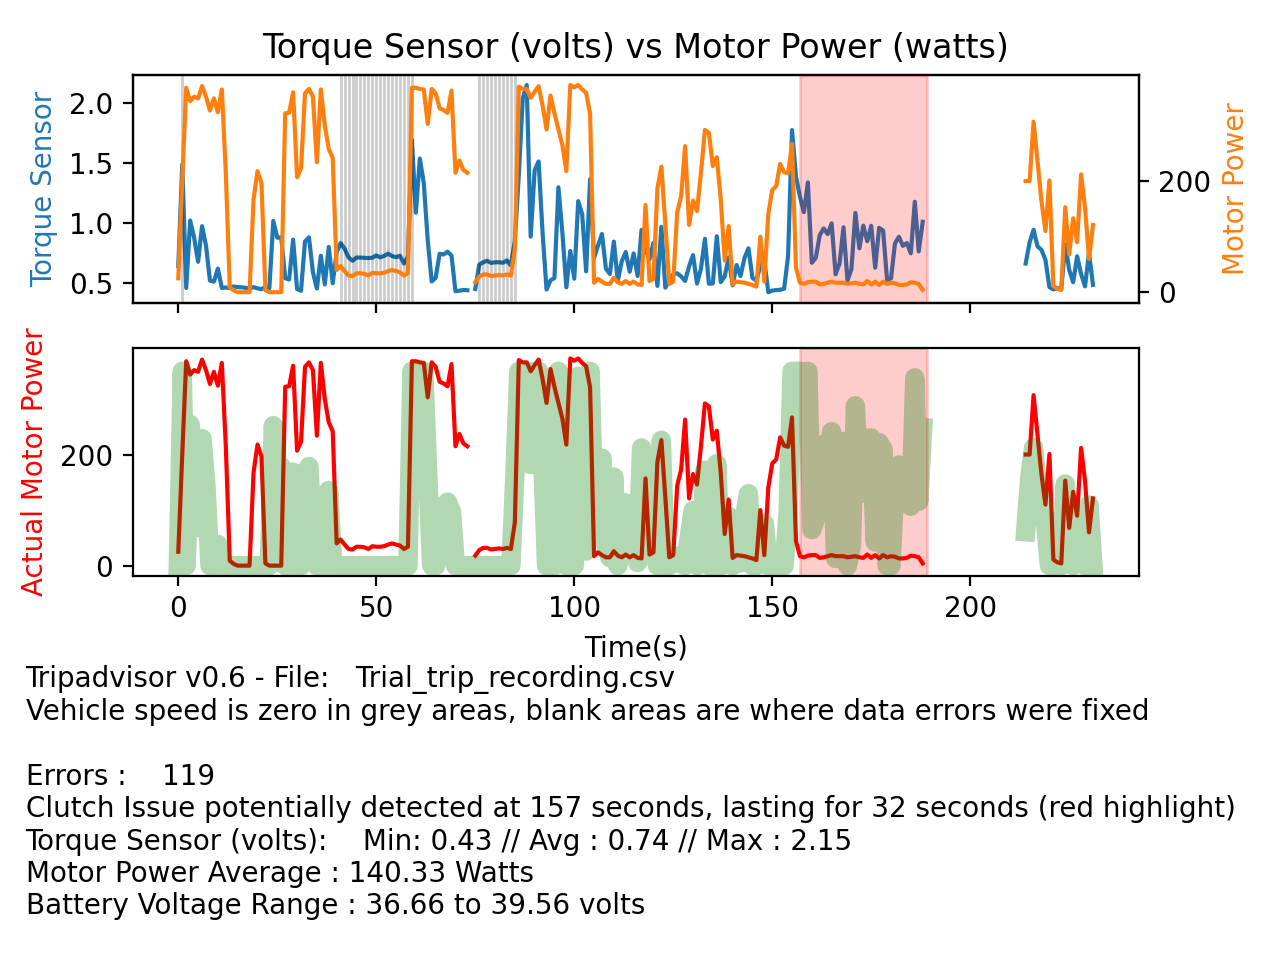